In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [32]:
df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter=';')

In [33]:
def match_outcome(df):
    relevant_df = df[df['description'].isin(['Goal', 'Pass'])]
    matches = relevant_df['match_id'].unique()
    match_data = []

    for match in matches:

        match_df = relevant_df[relevant_df['match_id'] == match].reset_index(drop=True)
        
        home_team_id = match_df['home_team_id'].iloc[0]
        away_team_id = match_df['away_team_id'].iloc[0]
        home_team_name = match_df['home_team_name'].iloc[0]
        away_team_name = match_df['away_team_name'].iloc[0]

        home_score = 0
        away_score = 0

        for i, row in match_df.iterrows():

            team_id = row['team_id']
            
            if team_id == home_team_id and row['description'] == 'Goal' and row['outcome'] == 1:
              
                if i + 1 < len(match_df):
                    next_row = match_df.iloc[i + 1]
                    
                    if next_row['team_id'] == home_team_id:
                        away_score += 1
                    else:
                        home_score += 1
                else:
                    home_score += 1
            elif team_id == away_team_id and row['description'] == 'Goal' and row['outcome'] == 1:
                
                if i + 1 < len(match_df):
                    next_row = match_df.iloc[i + 1]
                    if next_row['team_id'] == away_team_id:
                        home_score += 1
                    else:
                        away_score += 1
                else:
                    away_score += 1

        match_stats = {
            'match_id': match,
            'home_team': home_team_name,
            'away_team': away_team_name,
            'home_score': home_score,
            'away_score': away_score
        }

        match_data.append(match_stats)

    return pd.DataFrame(match_data)

In [34]:
matches_outcome = match_outcome(df)

In [35]:
df['x_float'] = df['x'].str.replace(',', '.').astype(float)
dangerous_area = (70, 100)
df['dangerous_zone'] = df['x_float'].apply(lambda x: 1 if dangerous_area[0] < x < dangerous_area[1] else 0)

In [36]:
defensive_events = {
    'Interception': {'successful': 1},
    'Save': {'successful': 1},
    'Ball recovery': {'successful': 1},
    'Error': {'unsuccessful': 1},
    'Offside provoked': {'successful': 1},
    'Shield ball opp': {'successful': 1},
    'Challenge': {'unsuccessful': 0},
    'Foul': {'unsuccessful': 0},  
    'Tackle': {'successful': 1, 'unsuccessful': 0},
    'Clearance': {'successful': 1, 'unsuccessful': 0},
    'Aerial': {'successful': 1, 'unsuccessful': 0},
}

In [37]:
# cuando la funcion encuentra algun evento -> pass
skip_events = {
    'Chance missed':None, 
    'Collection End':None, 
    'Cross not claimed':None, 
    'Deleted event':None, 
    'Formation change':None, 
    'Good skill':None, 
    'Team set up':None, 
    'Start':None, 
    'Temp_Attempt':None,
    'Out':1,
    'Clearance':0,
    'Corner awarded': 1,
    'Aerial': 0,
    'Take on':1,
    # 'Foul': 1,
    'Claim':None,
    'Penalty faced':None,
    'Player on': None,
    'Player off': None,
    'Player retired': None,
    'Save':None,
    'Shield ball opp': None,
    'Card': None,
    'Challenge':None,
    'Foul throw-in':None,
    'Offside provoked':None
}

In [38]:
stop_events = {
    'Attempt saved': None,
    'Ball recovery': None,
    'Ball touch': None,
    'Take on': 0,  # Stops play only if outcome == 0
    'Clearance': 1,  # Stops play only if outcome == 1
    'Contentious referee decision': None,
    'Corner awarded': 0,  # Stops play only if outcome == 0
    'Dispossessed': None,
    'Error': None,
    'Foul': 0,  # Stops play only if outcome == 0
    'Goal': None,
    'Interception': None,
    'Keeper pick-up': None,
    'Keeper sweeper': None,
    'Miss': None,
    'Offside pass': None,
    'Out': 0,  # Stops play only if outcome == 0
    'Post': None,
    'Punch': None,
    'Smother': None,
    'Start delay': None,
    'End delay': None,
    'Tackle': None,
    'Pass': 0  # Stops play only if outcome == 0
}

In [39]:
def group_plays(df, skip_events, stop_events, defensive_events):
    
    match_stats_list = []
    player_defensive_stats = {}
    unique_matches = df['match_id'].unique() 
    #unique_matches = [442374] /*--> para hacer los test*/

    for currentmatch in unique_matches:

        # para que sea mas rapido
        match_df = df[df['match_id'] == currentmatch].reset_index(drop=True)

        # me interesa para saber a quien le asigno la jugada (lo hacemos con team_id)
        home_team_id = match_df['home_team_id'].iloc[0]
        away_team_id = match_df['away_team_id'].iloc[0]

        #solo para devolver con el nombre y entender mejor (no es necesario para el analisis)
        home_team_name = match_df['home_team_name'].iloc[0]
        away_team_name = match_df['away_team_name'].iloc[0]

        #inicializamos todo en 0
        home_plays = 0
        away_plays = 0
        home_passes = 0
        away_passes = 0
        home_dangerous_play = 0
        away_dangerous_play = 0

        # antes de arrancar no esta en juego, no hay pases, no hay jugadas peligrosas y tampoco hay equipo asignado
        # variables "mas importantes"
        current_team = None
        in_play = False
        current_passes = 0
        play_in_danger_zone = []

        #arranca desde el 4 porque siempre desde esa row empiezan los eventos reales
        for i, row in match_df.iloc[4:].iterrows():
            #me quedo con el evento xq quiero ver si me sirve esa row o no 
            event = row['description']

            # si es uno de skip pasa a la siguiente fila (continue hace que pase una interacion del for)
            if event in skip_events:
                skip_condition = skip_events[event]
                if skip_condition is None or skip_condition == row['outcome']:
                    # print(f'Event type: {event}, ignored')
                    continue

            # si es un evento de los que frenan jugada es mas complicado
            # primero va a ver si esta en el diccionatrio
            if event in stop_events:
                # ahora agarra cual es la condicion (xq alufnos tienen en cuenta el outcome)
                # para que realmente sea stop
                stop_condition = stop_events[event]
                # si no tiene condicion va a entrar a frenar la jugada
                # si tiene condicion, se va a fijar que la condicion se cumpla
                if stop_condition is None or stop_condition == row['outcome']:
                    
                    if row['description'] in defensive_events:
                        # Get the outcome mappings for the event (successful/unsuccessful)
                        event_outcomes = defensive_events[row['description']]
                        
                        if row['outcome'] in event_outcomes.values():

                            player_name = row['playerName']
                            player_team = row['team_id']
                            player_position = row['playerPosition']

                            if player_name =='Nan' or player_name == 'nan':
                                pass
                            
                            else:
                                if player_name not in player_defensive_stats:
                                    player_defensive_stats[player_name] = {
                                        'team_id': player_team,
                                        'team_name': home_team_name if player_team == home_team_id else away_team_name,
                                        'playerName': player_name,
                                        'playerPosition': player_position,
                                        'stopped_plays': 0
                                    }

                                
                                event_outcome = [key for key, value in event_outcomes.items() if value == row['outcome']]
                                if event_outcome:
                                    
                                    player_defensive_stats[player_name]['stopped_plays'] += 1*(math.ceil(current_passes/10))
                    # si esta en juego...
                    #print(f'Event type: {event}, stop play')
                    if in_play:
                        # y el que estaba en juego es el home
                        if current_team == home_team_id:
                            #termina la jugada
                            home_plays += 1
                            # suma los pases acumulados a los pases del home
                            #print(f'Home passes current play: {current_passes}')
                            home_passes += current_passes
                            #se fija si hubieron jugadas peligrosas en la jugada
                            #print(f'Home passes total: {home_passes}')
                            if len(play_in_danger_zone)>3:
                                home_dangerous_play += 1
                        #idem para el away (todo lo mismo)
                        elif current_team == away_team_id:
                            away_plays += 1
                            #print(f'Away passes current play: {current_passes}')
                            away_passes += current_passes
                            #print(f'Away passes total: {away_passes}')
                            if len(play_in_danger_zone)>3:
                                away_dangerous_play += 1

                    # una vez que se hizo el update, se va a terminar la jugada
                    # se resetea todo 
                    # se pasa a la siguiente iteracion del for (continue)
                    #print(f'Play ends for team {current_team}')
                    current_team = None
                    in_play = False
                    current_passes = 0
                    play_in_danger_zone = []
                    continue

            # si no paso nada de skip o de stop empieza la jugada -> necesitamos los datos
            # primer dato= quien esta jugando -> lo vemos en team_id
            team_id = row['team_id']
            # segundo dato -> ver si la jugada es peligrosa
            dangerous_area = row['dangerous_zone']
            play_in_danger_zone.append(dangerous_area)

            # si no hay equipo asignado, asigno y le aviso que empieza una jgada (flag de in_play)
            if current_team is None:
                current_team = team_id
                in_play = True
                current_passes = 0

            #si estaba ya jugando, solo me interesa sumar pases ahora
            if current_team == team_id:
                if row['description']=='Pass' and row['outcome'] == 1:
                    #print(f'Pass on row {i} added')
                    current_passes += 1
            #hubo cambio de equipo
            else:
                if in_play:
                    #cierro jugada para el que estaba jugando (misma logica que cuando hay un stop event)
                    if current_team == home_team_id:
                        #termina la jugada
                        home_plays += 1
                        # suma los pases acumulados a los pases del home
                        #print(f'Home passes current play: {current_passes}')
                        home_passes += current_passes
                        #se fija si hubieron jugadas peligrosas en la jugada
                        #print(f'Home passes total: {home_passes}')
                        if len(play_in_danger_zone) >3:
                            home_dangerous_play += 1
                        
                        if row['description'] in defensive_events:
                            # Get the outcome mappings for the event (successful/unsuccessful)
                            event_outcomes = defensive_events[row['description']]
                            
                            if row['outcome'] in event_outcomes.values():
                                
                                player_name = row['playerName']
                                player_team = row['team_id']
                                player_position = row['playerPosition']

                                if player_name =='Nan' or player_name == 'nan':
                                    pass
                                
                                else:
                                    if player_name not in player_defensive_stats:
                                        player_defensive_stats[player_name] = {
                                            'team_id': player_team,
                                            'team_name': home_team_name if player_team == home_team_id else away_team_name,
                                            'playerName': player_name,
                                            'playerPosition': player_position,
                                            'stopped_plays': 0
                                        }

                                    
                                    event_outcome = [key for key, value in event_outcomes.items() if value == row['outcome']]
                                    if event_outcome:
                                        
                                        player_defensive_stats[player_name]['stopped_plays'] += 1*(math.ceil(current_passes/10))

                    #idem si el que estaba jugando era el de visitante
                    elif current_team == away_team_id:
                        away_plays += 1
                        #print(f'Away passes current play: {current_passes}')
                        away_passes += current_passes
                        #print(f'Away passes total: {away_passes}')
                        if len(play_in_danger_zone)>3:
                            away_dangerous_play += 1
                        
                        if row['description'] in defensive_events:
                            # Get the outcome mappings for the event (successful/unsuccessful)
                            event_outcomes = defensive_events[row['description']]
                            
                            if row['outcome'] in event_outcomes.values():
                                
                                player_name = row['playerName']
                                player_team = row['team_id']
                                player_position = row['playerPosition']

                                if player_name =='Nan' or player_name == 'nan':
                                    pass
                                
                                else:
                                    if player_name not in player_defensive_stats:
                                        player_defensive_stats[player_name] = {
                                            'team_id': player_team,
                                            'team_name': home_team_name if player_team == home_team_id else away_team_name,
                                            'playerName': player_name,
                                            'playerPosition': player_position,
                                            'stopped_plays': 0
                                        }

                                    
                                    event_outcome = [key for key, value in event_outcomes.items() if value == row['outcome']]
                                    if event_outcome:
                                        
                                        player_defensive_stats[player_name]['stopped_plays'] += 1*(math.ceil(current_passes/10))

                # empiezo la nueva jugada
                #print(f'Play ends for team {current_team}')

                current_team = team_id
                #print(f'New play starts for team {current_team}')
                in_play = True
                current_passes = 0
                play_in_danger_zone = []
    
        match_stats = {
            'match_id': currentmatch,
            'home_team': home_team_name,
            'away_team': away_team_name,
            'home_team_plays': home_plays,
            'away_team_plays': away_plays,
            'home_passes_per_play': round(home_passes / home_plays, 1) if home_plays > 0 else 0,
            'away_passes_per_play': round(away_passes / away_plays, 1) if away_plays > 0 else 0,
            'home_passes': home_passes,
            'away_passes': away_passes,
            'home_dangerous_plays': home_dangerous_play,
            'away_dangerous_plays': away_dangerous_play,
            'home_RPDA': f"{(away_dangerous_play / away_plays):.1%}",
            'away_RPDA': f"{(home_dangerous_play / home_plays):.1%}",
        }
        player_defensive_df = pd.DataFrame.from_dict(player_defensive_stats, orient='index')

        match_stats_list.append(match_stats)

    return pd.DataFrame(match_stats_list), player_defensive_df

In [40]:
full_information_df, player_defensive_df = group_plays(df, skip_events, stop_events, defensive_events)

In [11]:
full_information_df

,match_id,home_team,away_team,home_team_plays,away_team_plays,home_passes_per_play,away_passes_per_play,home_passes,away_passes,home_dangerous_plays,away_dangerous_plays,home_RPDA,away_RPDA
0,441999,Arsenal,Sunderland,154,113,4.3,2.1,663,238,63,23,20.4%,40.9%
1,442000,Everton,Manchester United,133,154,1.7,3.9,222,603,21,58,37.7%,15.8%
2,442001,Fulham,Norwich City,137,120,3.9,2.8,534,333,52,42,35.0%,38.0%
3,442002,Manchester City,Southampton,140,117,4.7,2.9,660,335,62,34,29.1%,44.3%
4,442003,Newcastle United,Tottenham Hotspur,130,134,2.8,2.5,364,332,40,42,31.3%,30.8%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,442374,Swansea City,Fulham,158,123,4.0,2.6,633,316,71,30,24.4%,44.9%
376,442375,Tottenham Hotspur,Sunderland,184,112,2.3,1.5,416,166,49,16,14.3%,26.6%
377,442376,West Bromwich Albion,Manchester United,119,139,2.3,4.0,271,551,34,58,41.7%,28.6%
378,442377,West Ham United,Reading,143,145,2.2,2.1,308,310,40,31,21.4%,28.0%


In [41]:
full_information_df.columns

Index(['match_id', 'home_team', 'away_team', 'home_team_plays',
       'away_team_plays', 'home_passes_per_play', 'away_passes_per_play',
       'home_passes', 'away_passes', 'home_dangerous_plays',
       'away_dangerous_plays', 'home_RPDA', 'away_RPDA'],
      dtype='object')

In [42]:
man_city_players = [ 'Hart, Joe',
'Zabaleta, Pablo',
'Clichy, Gael',
'Kompany, Vincent',
'Nastasic, Matija',
'Barry, Gareth',
'Nasri, Samir',
'Toure, Yaya',
'Aguero, Sergio',
'Tevez, Carlos',
'Silva, David']

In [43]:
(player_defensive_df[player_defensive_df['team_name']=='Manchester United']).sort_values(by='stopped_plays', ascending=False)

,team_id,team_name,playerName,playerPosition,stopped_plays
"Carrick, Michael",1,Manchester United,"Carrick, Michael",Midfielder,143
"Evra, Patrice",1,Manchester United,"Evra, Patrice",Defender,122
"da Silva, Rafael Pereira",1,Manchester United,"da Silva, Rafael Pereira",Defender,118
"Valencia, Luis Antonio",1,Manchester United,"Valencia, Luis Antonio",Midfielder,89
"Evans, Jonny",1,Manchester United,"Evans, Jonny",Substitute,74
"Ferdinand, Rio",1,Manchester United,"Ferdinand, Rio",Defender,73
"Rooney, Wayne",1,Manchester United,"Rooney, Wayne",Striker,68
"Vidic, Nemanja",1,Manchester United,"Vidic, Nemanja",Defender,60
"van Persie, Robin",1,Manchester United,"van Persie, Robin",Striker,57
"Cleverley, Tom",1,Manchester United,"Cleverley, Tom",Midfielder,56


In [14]:
(player_defensive_df.sort_values(by='stopped_plays', ascending=False)).to_excel('/Users/luisalawson/Downloads/player_playsStop.xlsx', index=False )

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_5895/3439998170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_united_df['total_passes'] = man_united_df.apply(lambda row: row['home_passes'] if row['home_team'] == 'Manchester United' else row['away_passes'], axis=1)
/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_5895/3439998170.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Overall', 'Home', 'Away'], y=[avg_passes_overall, avg_passes_home, avg_passes_away], palette='Blues_d')


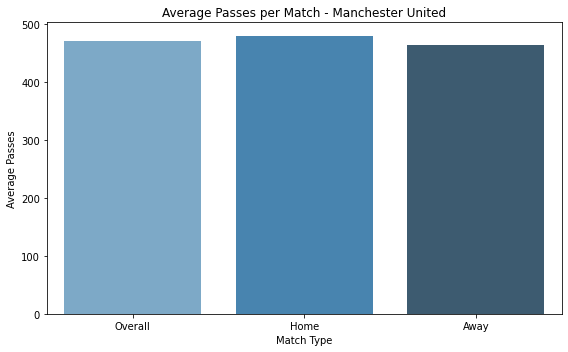

In [23]:
man_united_df = full_information_df[(full_information_df['home_team'] == 'Manchester United') | (full_information_df['away_team'] == 'Manchester United')]
man_united_df['total_passes'] = man_united_df.apply(lambda row: row['home_passes'] if row['home_team'] == 'Manchester United' else row['away_passes'], axis=1)
avg_passes_overall = man_united_df['total_passes'].mean()
avg_passes_home = man_united_df[man_united_df['home_team'] == 'Manchester United']['home_passes'].mean()
avg_passes_away = man_united_df[man_united_df['away_team'] == 'Manchester United']['away_passes'].mean()

# Plotting the graph
plt.figure(figsize=(8, 5))
sns.barplot(x=['Overall', 'Home', 'Away'], y=[avg_passes_overall, avg_passes_home, avg_passes_away], palette='Blues_d')
plt.title('Average Passes per Match - Manchester United')
plt.ylabel('Average Passes')
plt.xlabel('Match Type')
plt.tight_layout()
plt.show()

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_5895/2739561762.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opponent', y='Average Passes', data=avg_passes_vs_opponent, palette='Greens_d')


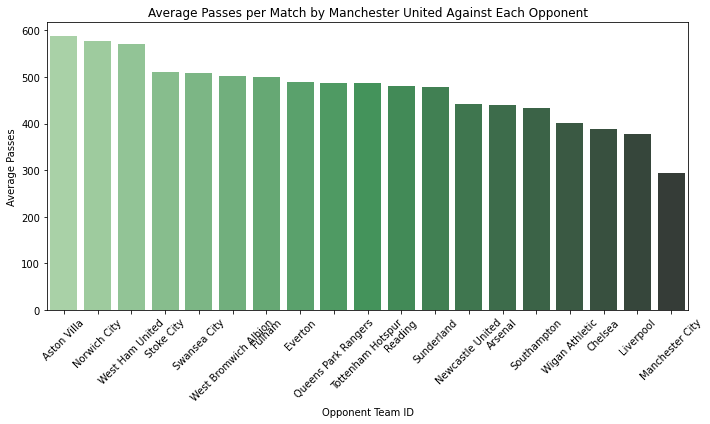

In [27]:

opponents = man_united_df.apply(lambda row: row['away_team'] if row['home_team'] == 'Manchester United' else row['home_team'], axis=1).unique()

# Initialize an empty list to store each row of data
avg_passes_vs_opponent_list = []

for opponent in opponents:
    # Filter matches where Man Utd faced this opponent
    matches_against_opponent = man_united_df[
        ((man_united_df['home_team'] == 'Manchester United') & (man_united_df['away_team'] == opponent)) | 
        ((man_united_df['away_team'] == 'Manchester United') & (man_united_df['home_team'] == opponent))
    ]
    
    # Calculate average passes by Man Utd in these matches
    avg_passes = matches_against_opponent['total_passes'].mean()
    
    # Append the result as a dictionary to the list
    avg_passes_vs_opponent_list.append({'Opponent': opponent, 'Average Passes': avg_passes})

# Convert the list of dictionaries into a DataFrame
avg_passes_vs_opponent = pd.DataFrame(avg_passes_vs_opponent_list)
avg_passes_vs_opponent = avg_passes_vs_opponent.sort_values(by='Average Passes', ascending=False)

# Plotting the graph
plt.figure(figsize=(10, 6))
sns.barplot(x='Opponent', y='Average Passes', data=avg_passes_vs_opponent, palette='Greens_d')
plt.title('Average Passes per Match by Manchester United Against Each Opponent')
plt.ylabel('Average Passes')
plt.xlabel('Opponent Team ID')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_5895/3319734005.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Opponent', y='Average Dangerous Plays', data=avg_dangerous_plays_vs_opponent, palette='Reds_d')


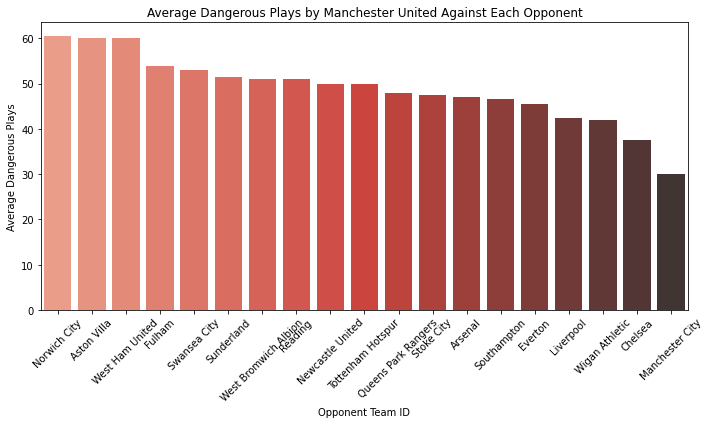

In [30]:
# Initialize an empty list to store the data for each opponent
avg_dangerous_plays_vs_opponent_list = []

for opponent in opponents:
    # Filter matches where Man Utd faced this opponent
    matches_against_opponent = man_united_df[
        ((man_united_df['home_team'] == 'Manchester United') & (man_united_df['away_team'] == opponent)) | 
        ((man_united_df['away_team'] == 'Manchester United') & (man_united_df['home_team'] == opponent))
    ]
    
    # Calculate average dangerous plays by Man Utd in these matches
    avg_dangerous_plays = matches_against_opponent.apply(
        lambda row: row['home_dangerous_plays'] if row['home_team'] == 'Manchester United' else row['away_dangerous_plays'], 
        axis=1
    ).mean()
    
    # Append the result as a dictionary to the list
    avg_dangerous_plays_vs_opponent_list.append({'Opponent': opponent, 'Average Dangerous Plays': avg_dangerous_plays})

# Convert the list of dictionaries into a DataFrame
avg_dangerous_plays_vs_opponent = pd.DataFrame(avg_dangerous_plays_vs_opponent_list)
avg_dangerous_plays_vs_opponent = avg_dangerous_plays_vs_opponent.sort_values(by = 'Average Dangerous Plays', ascending= False)
# Plotting the graph
plt.figure(figsize=(10, 6))
sns.barplot(x='Opponent', y='Average Dangerous Plays', data=avg_dangerous_plays_vs_opponent, palette='Reds_d')
plt.title('Average Dangerous Plays by Manchester United Against Each Opponent')
plt.ylabel('Average Dangerous Plays')
plt.xlabel('Opponent Team ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [62]:
complete_df = pd.merge(full_information_df, matches_outcome.drop(columns=['match_id', 'home_team', 'away_team']), left_index=True, right_index=True, how='left')

In [55]:
excel_file_path = '/Users/luisalawson/Downloads/complete_df.xlsx'  

complete_df.to_excel(excel_file_path, index=False)
print(f"DataFrame saved to {excel_file_path}")

DataFrame saved to /Users/luisalawson/Downloads/complete_df.xlsx
